In [1]:
import importlib
import tempfile
import os
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt
from ics.hxutils import hxramp
from h4rg_analysis import io, ramputils
import makefigures_noise

In [2]:
def scaled_imshow ( im, ax=None, beta=0.01, colorbar=True ):
    if ax is None:
        ax = plt.subplot(111)
    vmin, vmax = np.nanquantile ( im, [beta, 1. - beta] )
    imout = ax.imshow ( im, vmin=vmin, vmax=vmax)
    if colorbar:
        plt.colorbar ( imout, ax=ax )
    return ax

def recast (colmed, dt):
    recast = np.ones(dt.size, dtype=float)
    for idx,dindex in enumerate(np.unique(dt)):
        recast[dt==dindex] = colmed[idx]    
    return recast

In [3]:
bestbaselines = open ('../data/paths/best_ever_baseline_darks_8_21_2022.txt', 'r').read().splitlines()[1:]
rampids = makefigures_noise.load_rampids ()

In [4]:
rampA = hxramp.HxRamp(io.jhu2tiger(bestbaselines[0]))
rampB = hxramp.HxRamp(io.jhu2tiger(bestbaselines[1]))

In [5]:
nbins = 5
step = rampA.ncols // nbins
sl_indices = np.concatenate ( [np.arange(0, rampA.ncols, step)[:-1], [rampA.ncols+1]] )
slices = [ slice(sl_indices[idx], sl_indices[idx+1]) for idx in range(sl_indices.size-1) ]

In [24]:
im0 = rampA.dataN(0)
im1 = rampA.dataN(1)

In [7]:
irp0 = rampA.irpN(0)
irp1 = rampA.irpN(1)

<AxesSubplot:>

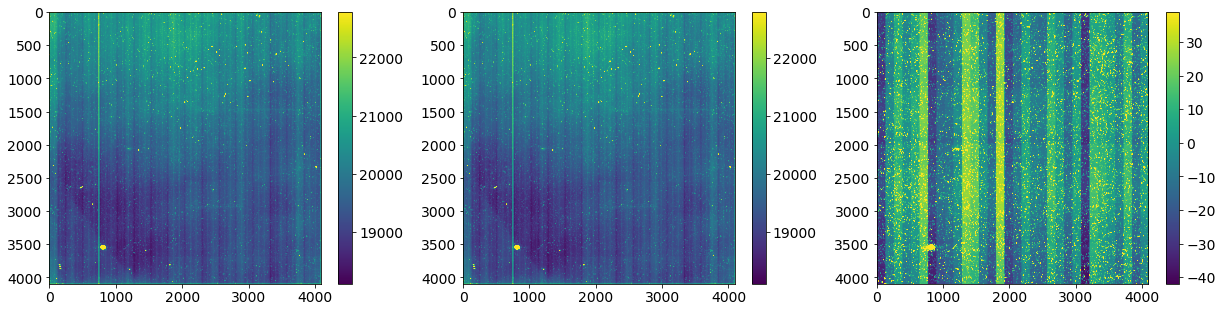

In [25]:
fig, axarr = plt.subplots(1,3, figsize=(21,5))
scaled_imshow(im0, ax=axarr[0])
scaled_imshow(im1, ax=axarr[1])
scaled_imshow(im1.astype(float)-im0.astype(float), ax=axarr[2])

<AxesSubplot:>

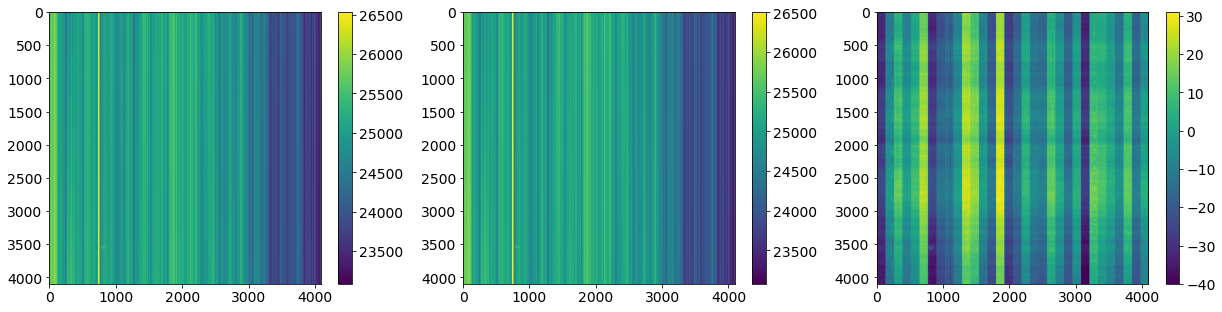

In [9]:
fig, axarr = plt.subplots(1,3, figsize=(21,5))
scaled_imshow(irp0, ax=axarr[0])
scaled_imshow(irp1, ax=axarr[1])
scaled_imshow(irp1.astype(float)-irp0.astype(float), ax=axarr[2] )

<AxesSubplot:>

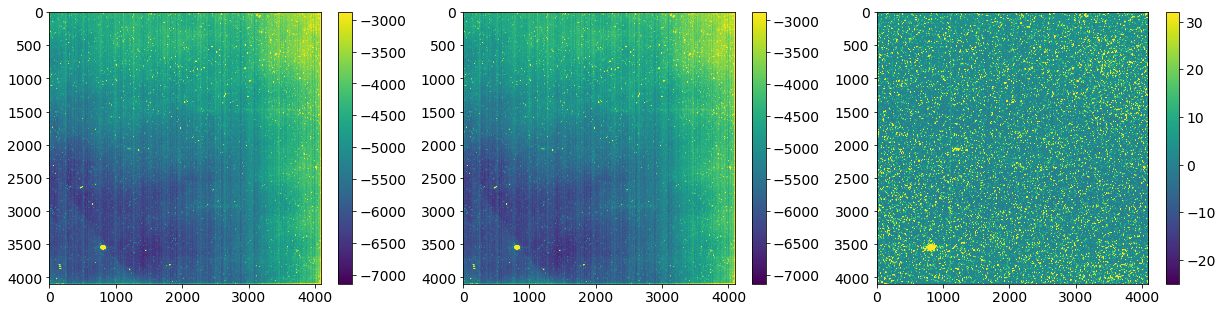

In [26]:
fig, axarr = plt.subplots(1,3, figsize=(21,5))

d0 = im0.astype(float)-irp0.astype(float)
d1 = im1.astype(float)-irp1.astype(float)
scaled_imshow(d0, ax=axarr[0])
scaled_imshow(d1, ax=axarr[1])
scaled_imshow(d1-d0, ax=axarr[2] )

In [10]:
irpdiff = irp1.astype(float)-irp0.astype(float)

In [11]:
from scipy import ndimage

In [12]:
xs = np.arange(irpdiff.shape[1])
bins = np.arange(0,xs.max() + 2, 128)
midpts = 0.5*(bins[1:]+bins[:-1])
dt = np.digitize (xs, bins)


In [13]:
rowmed = np.median ( irpdiff, axis=0 )
colmed = ndimage.median ( rowmed, labels=dt, index=np.unique(dt) )

In [14]:
recrow = recast ( colmed, dt )

In [15]:
from scipy import stats

In [16]:
rowdiff = rowmed - recrow
sclip = stats.sigmaclip(rowdiff)
cpd_diff = irpdiff.copy ()
cpd_diff[:,(rowdiff>sclip.upper)|(rowdiff<sclip.lower)] = np.NaN
cpd_rowmed = np.nanmedian(cpd_diff, axis=0)
cpd_colmed = ndimage.median ( cpd_rowmed, labels=dt, index=np.unique(dt) )

/tigress/kadofong/machine_harmony/repos_post0903/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


In [17]:
clist = np.random.uniform(0.,1., [bins.size-1, 3])
cmap = colors.LinearSegmentedColormap.from_list ( 'random', clist, bins.size-1 )
recast = recast ( cpd_colmed, dt)

In [18]:
normalized = np.ones(irpdiff.shape, dtype=float)*recast

<AxesSubplot:xlabel='x', ylabel='y'>

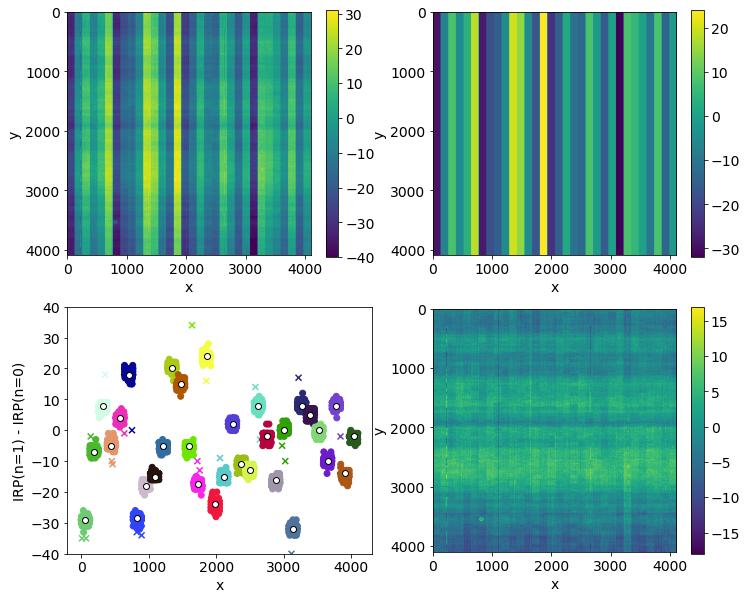

In [19]:
fig, axarr = plt.subplots(2,2, figsize=(12,10))

scaled_imshow(irpdiff, ax=axarr[0,0])
scaled_imshow(normalized, ax=axarr[0,1])

rmvd = np.isnan(cpd_rowmed)
axarr[1,0].scatter(xs[rmvd], rowmed[rmvd], marker='x', c=dt[rmvd], cmap=cmap, vmin=dt.min(), vmax=dt.max())
axarr[1,0].scatter(xs, cpd_rowmed, c=dt, cmap=cmap)
axarr[1,0].scatter ( midpts, colmed, ec='k', fc='w')
axarr[1,0].set_ylim(-40,40)
for ax in axarr.flatten():
    ax.set_xlabel ( 'x' )
for ax in axarr[0]:
    ax.set_ylabel('y')
axarr[1,0].set_ylabel(r'IRP(n=1) - IRP(n=0)')
axarr[1,1].set_ylabel('y')
scaled_imshow(irpdiff-normalized, ax=axarr[1,1] )

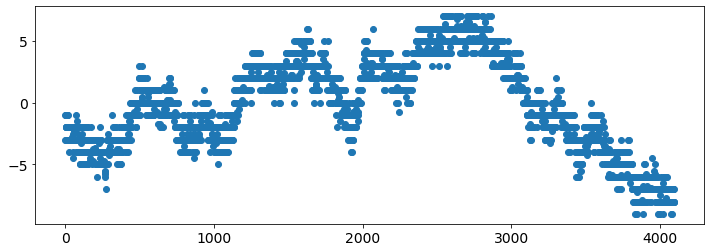

In [20]:
adjusted = irpdiff-normalized

plt.figure(figsize=(12,4))
plt.scatter(xs, np.median(adjusted,axis=1))

In [39]:
irp0 = rampA.irpN ( 0 )

pcmed = np.zeros([300, 4096])
prmed = np.zeros([300, 32])
for idx in range(300):
    irp1 = rampA.irpN(idx+1)
    fncd = ramputils.correct_IRPpcv ( irp1, irp0 )
    pcmed[idx] = np.median(fncd,axis=1)
    prmed[idx] = 
    irp0 = irp1
    if idx > 1:
        break

/tigress/kadofong/machine_harmony/repos_post0903/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


<AxesSubplot:>

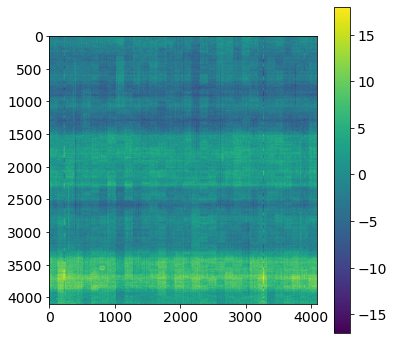

In [44]:
scaled_imshow(fncd)

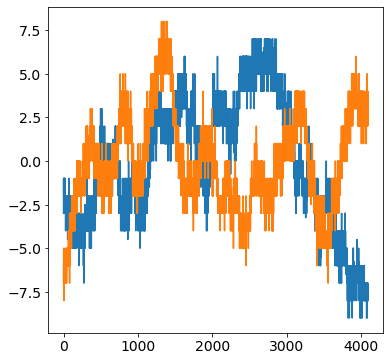

In [40]:
plt.plot(pcmed[0])
plt.plot(pcmed[1])

(0.0, 4096.0)

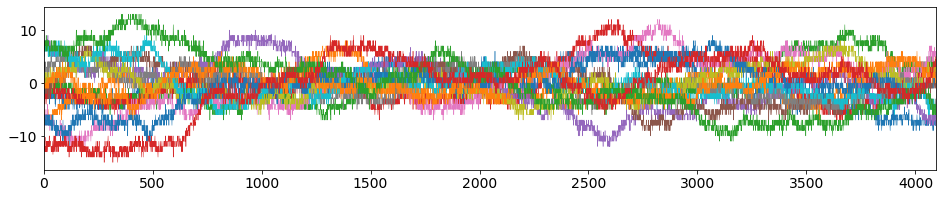

In [34]:
plt.figure(figsize=(16,3))
for jdx in range(idx):
    plt.plot(pcmed[jdx], lw=0.5)
plt.xlim(0,4096)